# MORE EFFICIENT PORTFOLIO ALLOCATION WITH QUASI-MONTE CARLO METHODS USING QMCPY
Larysa Matiukha and Sou-Cheng T. Choi

Illinois Institute of Technology

Modification date: 12/13/2025

In [1]:
import qmcpy as qp
import pandas as pd
import numpy as np
import random

try:
    import yfinance as yf
except ImportError:
    !pip install -q yfinance
    import yfinance as yf

import seaborn as sn
import matplotlib.pyplot as plt
import time

# from scipy.optimize import minimize
import timeit

from pathlib import Path

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

In [2]:
# make folders `data` and `images`
import os
data_dir = 'data' + os.sep
images_dir = 'images' + os.sep
if not os.path.exists('data'):
    os.makedirs(data_dir)
if not os.path.exists('images'):
    os.makedirs(images_dir)

*Portfolio allocation* is a strategic process that aims to balance risk and return by distributing funds among diverse assets with varying risks and returns [5]. The goal is to create a diversified portfolio that can mitigate risk and  enhance returns over time, while  reducing the impact of market changes on individual assets. In this study for portfolio allocation, utilizing the open-source QMCPy library[2,3], we apply quasi-Monte Carlo methods in the distribution of funds among individual stocks in a portfolio.

In [3]:
start_date = '2014-01-01'
#today = date.today()
end_date = '2025-12-13'

In [4]:
# Define sampler types and visualization parameters
sampler_types = ['iid', 'lattice', 'sobol', 'halton']
colors = ['magenta', 'indigo', 'limegreen', 'blue']
markers = ['D', 'o', 's', '^']

# Map sampler types to QMCPy classes
sampler_classes = {
    'lattice': qp.Lattice,
    'sobol': qp.Sobol,
    'halton': qp.Halton,
    'iid': qp.IIDStdUniform
}

In [5]:
def download_data(tickers, description):
    col_names = ['Ticker', 'Company', 'Date', 'Adj Close Price', 'Volume']
    rows = []
    for i, ticker in enumerate(tickers):
        company = description[i]
        data = yf.download(ticker, start=start_date, end=end_date)
        if data.empty:
            print(f"Warning: no data for {ticker}")
            continue
        data = data.reset_index()
        
        # Handle column names robustly (could be MultiIndex or different names)
        cols = list(data.columns)
        
        # Find date column
        date_col = next((c for c in cols if 'Date' in str(c) or 'date' in str(c)), cols[0])
        
        # Find adj close column
        adj_col_candidates = [c for c in cols if 'Adj' in str(c)]
        if not adj_col_candidates:
            adj_col_candidates = [c for c in cols if 'Close' in str(c)]
        
        # Find volume column
        vol_col_candidates = [c for c in cols if 'Volume' in str(c) or 'Vol' in str(c)]
        
        if not adj_col_candidates or not vol_col_candidates:
            raise KeyError(f"Adj Close or Volume column not found for {ticker}. Columns: {cols}")
        
        adj_col_sel = adj_col_candidates[0]
        vol_col_sel = vol_col_candidates[0]
        
        # Select and rename columns
        data = data[[date_col, adj_col_sel, vol_col_sel]].copy()
        data.insert(0, 'Company', company)
        data.insert(0, 'Ticker', ticker)
        data.columns = col_names
        rows.append(data)
    
    df = pd.concat(rows, ignore_index=True)
    return df


In [6]:
def get_log_ret(df):
    stocks = df.pivot(index='Date', columns='Ticker', values='Adj Close Price')
    log_ret = np.log(stocks/stocks.shift(1))

    return log_ret.dropna()
    

# Generating Portfolio Weights

We implement functions to generate portfolio weights using different sampling methods:
- **Lattice** (QMC) — Low-discrepancy sequence with good space-filling properties
- **Sobol** (QMC) — Another low-discrepancy sequence, popular in finance
- **Halton** (QMC) — Low-discrepancy sequence based on prime bases
- **IID** (MC) — Traditional Monte Carlo with pseudo-random uniform samples

The weights are normalized to sum to 1 for each portfolio (simplex constraint).

In [7]:
def gen_weights(sampler_type, n_tickers, n_ports, seed=42):
    """
    Generate portfolio weights using specified sampling method.
    
    Parameters:
        sampler_type: str - 'lattice', 'sobol', 'halton', or 'iid'
        n_tickers: int - number of assets (dimension)
        n_ports: int - number of portfolios to generate
        seed: int - random seed for reproducibility
    
    Returns:
        weights: ndarray of shape (n_ports, n_tickers) with rows summing to 1
    """
    if sampler_type not in sampler_classes:
        raise ValueError(f"Unknown sampler type: {sampler_type}. Must be one of {list(sampler_classes.keys())}")
    
    sampler = sampler_classes[sampler_type](dimension=n_tickers, seed=seed)
    weights = sampler.gen_samples(n_ports)
    
    # Normalize weights to sum to 1 (simplex projection)
    weights /= weights.sum(axis=1, keepdims=True)
    return weights

In [8]:
def gen_weights_reps(sampler_type, n_tickers, n_ports, replications, seed=42):
    """
    Generate portfolio weights with replications using specified sampling method.
    
    Parameters:
        sampler_type: str - 'lattice', 'sobol', 'halton', or 'iid'
        n_tickers: int - number of assets (dimension)
        n_ports: int - number of portfolios per replication
        replications: int - number of replications
        seed: int - random seed for reproducibility
    
    Returns:
        weights: ndarray of shape (replications, n_ports, n_tickers) with rows summing to 1
    """
    if sampler_type not in sampler_classes:
        raise ValueError(f"Unknown sampler type: {sampler_type}. Must be one of {list(sampler_classes.keys())}")
    
    sampler = sampler_classes[sampler_type](dimension=n_tickers, replications=replications, seed=seed)
    weights = sampler.gen_samples(n_ports)
    
    # Normalize weights to sum to 1 (simplex projection)
    weights /= weights.sum(axis=2, keepdims=True)
    return weights

## Computing Sharpe Ratio
Sharpe Ratio is given by: $\frac{R}{V}$, where $R = \sum_{i=1}^{d} R_iw_i$ stands for the excess expected return of a portfolio and $V = \sqrt{\sum_{i=1}^{d} \sum_{j=1}^{d} \sigma_{ij} w_i w_j}$ represents  its expected volatility with $d$ number of assets in a portfolio, weights $w_i$'s, and covariance of assets $i$ and $j$ $\sigma_{ij}$

In [9]:
def sharpe(weights,log_ret):
    # Expected return
    ret_arr = np.sum((log_ret.mean().values * weights * 252), axis=1)

    # Expected volatility
    vol_arr = np.sqrt((weights @ (log_ret.cov().values * 252)) @ weights.T).diagonal()

    # Sharpe Ratio
    sharpe_arr = ret_arr/vol_arr

    # Risk levels
    medium_risk_tolerance = np.quantile(vol_arr, 2/3, axis=0)
    low_risk_tolerance = np.quantile(vol_arr, 1/3, axis=0)

    medium_risk_idx = np.where(vol_arr<medium_risk_tolerance)
    low_risk_idx = np.where(vol_arr<low_risk_tolerance)
    
    # High risk
    high_idx = sharpe_arr.argmax()

    # Medium risk
    medium_rel_idx = sharpe_arr[medium_risk_idx].argmax()
    medium_idx = medium_risk_idx[0][medium_rel_idx]

    # Low risk
    low_rel_idx = sharpe_arr[low_risk_idx].argmax() 
    low_idx = low_risk_idx[0][low_rel_idx]

    return {
        "number of tickers": weights.shape[1],
        "number of portfolios": weights.shape[0],

        "low": np.round(weights[low_idx], 3).tolist(),
        "medium": np.round(weights[medium_idx], 3).tolist(),
        "high": np.round(weights[high_idx], 3).tolist(),

        "low risk Sharpe": np.round(sharpe_arr[low_idx], 3),
        "medium risk Sharpe": np.round(sharpe_arr[medium_idx], 3),
        "high risk Sharpe": np.round(sharpe_arr[high_idx], 3),
    }


In [10]:
def sharpe_reps(weights, log_ret):

    R, P, D = weights.shape # (Replications, Portfolios, Dimension); Dimension = number of tickers 
    
    # Expected return
    ret_arr = np.sum((weights * log_ret.mean().values * 252), axis=2)

    # Volatility 
    vol_arr = np.sqrt(np.sum(weights @ (log_ret.cov().values * 252) * weights, axis=2))

    # Sharpe ratio
    sharpe_arr = ret_arr / vol_arr                

    low_risk_max_sharpe_ratio = []
    medium_risk_max_sharpe_ratio = []
    max_sharpe_ratio = []

    for r in range(R):
        vol_r = vol_arr[r]
        sharpe_r = sharpe_arr[r]

        # risk tolerance for each replication
        low_risk_tolerance = np.quantile(vol_r, 1/3)
        medium_risk_tolerance = np.quantile(vol_r, 2/3)

        low_risk_idx = np.where(vol_r < low_risk_tolerance)[0]
        medium_risk_idx = np.where(vol_r < medium_risk_tolerance)[0]

        max_sharpe_ratio.append(sharpe_r.max())
        medium_risk_max_sharpe_ratio.append(sharpe_r[medium_risk_idx].max())
        low_risk_max_sharpe_ratio.append(sharpe_r[low_risk_idx ].max())

    return {
        "number of tickers": D,
        "number of portfolios": P,
        "replications": R,

        "low risk Sharpe": np.round(np.mean(low_risk_max_sharpe_ratio), 3),
        "medium risk Sharpe": np.round(np.mean(medium_risk_max_sharpe_ratio), 3),
        "high risk Sharpe": np.round(np.mean(max_sharpe_ratio), 3),
    }


In [11]:
def sharpe(weights, log_ret):
    """Compute Sharpe ratios for portfolios at three risk levels."""
    # Expected return
    ret_arr = np.sum((log_ret.mean().values * weights * 252), axis=1)

    # Expected volatility
    vol_arr = np.sqrt((weights @ (log_ret.cov().values * 252)) @ weights.T).diagonal()

    # Sharpe Ratio
    sharpe_arr = ret_arr / vol_arr

    # Rounding values
    sharpe_arr_rounded = np.round(sharpe_arr, decimals=3)
    ret_arr_rounded = np.round(ret_arr, decimals=3)
    vol_arr_rounded = np.round(vol_arr, decimals=3)
    all_weights = np.round(weights, decimals=3)

    # Find best Sharpe ratio at each risk level
    low_risk_tolerance = np.quantile(vol_arr_rounded, 1/3, axis=0)
    medium_risk_tolerance = np.quantile(vol_arr_rounded, 2/3, axis=0)
    
    low_risk_idx = np.where(vol_arr_rounded <= low_risk_tolerance)[0]
    medium_risk_idx = np.where(vol_arr_rounded <= medium_risk_tolerance)[0]
    
    # High risk (max Sharpe overall)
    high_idx = np.argmax(sharpe_arr)
    
    # Medium risk
    medium_idx = medium_risk_idx[np.argmax(sharpe_arr[medium_risk_idx])]
    
    # Low risk
    low_idx = low_risk_idx[np.argmax(sharpe_arr[low_risk_idx])]

    return {
        "number of tickers": weights.shape[1],
        "number of portfolios": weights.shape[0],
        "low": all_weights[low_idx].tolist(),
        "medium": all_weights[medium_idx].tolist(),
        "high": all_weights[high_idx].tolist(),
        "low risk Sharpe": np.round(sharpe_arr[low_idx], 3),
        "medium risk Sharpe": np.round(sharpe_arr[medium_idx], 3),
        "high risk Sharpe": np.round(sharpe_arr[high_idx], 3)
    }

In [12]:
def evaluate_sampler_sharpe(sampler_type, log_ret, n_ports, seed=42):
    
    n_tickers = log_ret.shape[1]
    rows = []

    for ports in n_ports:
        weights = gen_weights(sampler_type, n_tickers, ports, seed)
        sr = sharpe(weights, log_ret)

        rows.append({
            'sampler': sampler_type,
            'number of tickers': n_tickers,
            'number of portfolios': ports,
            'low risk Sharpe': sr['low risk Sharpe'],
            'medium risk Sharpe': sr['medium risk Sharpe'],
            'high risk Sharpe': sr['high risk Sharpe'],
        })

    return pd.DataFrame(rows)

In [13]:
def evaluate_sampler_sharpe_reps(sampler_type, log_ret, n_ports, replications, seed=42):
    
    n_tickers = log_ret.shape[1]
    rows = []

    for ports in n_ports:
        weights = gen_weights_reps(sampler_type, n_tickers, ports, replications, seed)
        sr = sharpe_reps(weights, log_ret)

        rows.append({
            'sampler': sampler_type,
            'number of tickers': n_tickers,
            'number of portfolios': ports,
            'replications': replications,
            'low risk Sharpe': sr['low risk Sharpe'],
            'medium risk Sharpe': sr['medium risk Sharpe'],
            'high risk Sharpe': sr['high risk Sharpe'],
        })

    return pd.DataFrame(rows)

# Testing Sharpe ratios
We now test the two approaches by computing Sharpe ratios at different risk levels employing the weights obtained from each method.

As we can see from the tables below, the values of Sharpe ratio do not significantly change based on the number of portfolios. We might want to look furher into this: will results change more significantly if we triple the number of portfolios for the tickers we worked with, or what happens if we use much greater number of tickers to begin with.


## Testing Sharpe ratios for four tickers
We start with obtaining the data for four tickers and generate three different arrays of weights for the tickers using lattice points. We then compute the Sharpe ratios for three different levels of risk strategies using the log returns and the generated weights. 

In [14]:
tickers = ["AAPL", "AMZN", "CSCO", "IBM"]
description = ["Apple", "Amazon", "CISCO", "IBM"]

fname = f"{data_dir}df_{start_date}_to_{end_date}.csv"
p = Path(fname)

if p.exists():
    df = pd.read_csv(p, parse_dates=['Date'])
else:
    df = download_data(tickers,description)
    df.to_csv(p, index=False)

lr = get_log_ret(df)
n_ports = [2**13, 2**14, 2**15]

df_results = pd.concat([evaluate_sampler_sharpe(st, lr, n_ports) for st in sampler_types])

df_results

,sampler,number of tickers,number of portfolios,low risk Sharpe,medium risk Sharpe,high risk Sharpe
0,iid,4,8192,0.810,0.839,0.859
1,iid,4,16384,0.810,0.839,0.859
2,iid,4,32768,0.810,0.839,0.859
0,lattice,4,8192,0.810,0.838,0.859
1,lattice,4,16384,0.810,0.839,0.859
2,lattice,4,32768,0.810,0.839,0.859
0,sobol,4,8192,0.809,0.838,0.859
1,sobol,4,16384,0.809,0.838,0.859
2,sobol,4,32768,0.810,0.838,0.859
0,halton,4,8192,0.810,0.838,0.859


In [15]:
lr = get_log_ret(df)
n_ports = [2**13, 2**14, 2**15]
replications = 50
df_results_reps = pd.concat([evaluate_sampler_sharpe_reps(st, lr, n_ports, replications) for st in sampler_types])
df_results_reps

,sampler,number of tickers,number of portfolios,replications,low risk Sharpe,medium risk Sharpe,high risk Sharpe
0,iid,4,8192,50,0.807,0.838,0.859
1,iid,4,16384,50,0.807,0.838,0.859
2,iid,4,32768,50,0.808,0.838,0.859
0,lattice,4,8192,50,0.807,0.838,0.859
1,lattice,4,16384,50,0.808,0.838,0.859
2,lattice,4,32768,50,0.808,0.838,0.859
0,sobol,4,8192,50,0.807,0.838,0.859
1,sobol,4,16384,50,0.808,0.838,0.859
2,sobol,4,32768,50,0.808,0.838,0.859
0,halton,4,8192,50,0.807,0.838,0.859


## Testing Sharpe ratios with lattice weights for ten tickers

Now, we dowload the data for 10 tickers and generate new weights using lattice points and compute the Sharpe ratios. We use the same number of portfolios (sampling points) as in the case with four tickers.

In [16]:

tickers1 = ["AAPL", "AMZN", "CSCO", "IBM", "TSLA", "META", "ABNB", "UPS", "NFLX", "MRNA"]
description1 = ["Apple", "Amazon", "CISCO", "IBM", "Tesla", "Meta", "Airbnb", "UPS", "Netflix", "Moderna"]

fname = f"{data_dir}df1_{start_date}_to_{end_date}.csv"
p = Path(fname)

if p.exists():
    df1 = pd.read_csv(p, parse_dates=['Date'])
else:
    df1 = download_data(tickers1,description1)
    df1.to_csv(p, index=False)

# compute log returns and QMC results (use actual number of tickers downloaded)
lr1 = get_log_ret(df1)
n_ports = [2**13, 2**14, 2**15]

df1_results = pd.concat([evaluate_sampler_sharpe(st, lr1, n_ports) for st in sampler_types])

df1_results

,sampler,number of tickers,number of portfolios,low risk Sharpe,medium risk Sharpe,high risk Sharpe
0,iid,10,8192,0.686,0.686,0.686
1,iid,10,16384,0.686,0.686,0.686
2,iid,10,32768,0.695,0.695,0.695
0,lattice,10,8192,0.711,0.711,0.711
1,lattice,10,16384,0.712,0.712,0.712
2,lattice,10,32768,0.821,0.821,0.821
0,sobol,10,8192,0.823,0.823,0.823
1,sobol,10,16384,0.823,0.823,0.823
2,sobol,10,32768,0.823,0.823,0.823
0,halton,10,8192,0.730,0.730,0.730


In [17]:
df1_results_reps = pd.concat([evaluate_sampler_sharpe_reps(st, lr1, n_ports, replications) for st in sampler_types])
df1_results_reps

,sampler,number of tickers,number of portfolios,replications,low risk Sharpe,medium risk Sharpe,high risk Sharpe
0,iid,10,8192,50,0.712,0.712,0.712
1,iid,10,16384,50,0.730,0.730,0.730
2,iid,10,32768,50,0.755,0.755,0.755
0,lattice,10,8192,50,0.723,0.723,0.723
1,lattice,10,16384,50,0.736,0.736,0.736
2,lattice,10,32768,50,0.757,0.757,0.757
0,sobol,10,8192,50,0.725,0.725,0.725
1,sobol,10,16384,50,0.750,0.750,0.750
2,sobol,10,32768,50,0.765,0.765,0.765
0,halton,10,8192,50,0.733,0.733,0.733


## Testing Sharpe ratios  for twenty tickers


In [18]:
tickers2 = ["AAPL", "AMZN", "CSCO","IBM","TSLA","META","ABNB","UPS","NFLX","MRNA","^IXIC", "T","GE","FMC","AMC","JPM","DIS","CVX","GOOGL","BA"]
description2 = ["Apple", "Amazon", "CISCO", "IBM","Tesla","Meta","Airbnb","UPS","Netflix","Moderna","NASDAQ","AT&T","General Electric","FMC","AMC","JPMorgan","Disney","Chevron","Google","Boeing"]

fname = f"{data_dir}df2_{start_date}_to_{end_date}.csv"
p = Path(fname)

if p.exists():
    df2 = pd.read_csv(p, parse_dates=['Date'])
    
else:
    df2 = download_data(tickers2,description2)
    df2.to_csv(p, index=False)

lr2 = get_log_ret(df2)
n_ports = [2**13, 2**14, 2**15]

df2_results = pd.concat([evaluate_sampler_sharpe(st, lr2, n_ports) for st in sampler_types])

df2_results

,sampler,number of tickers,number of portfolios,low risk Sharpe,medium risk Sharpe,high risk Sharpe
0,iid,20,8192,0.692,0.692,0.692
1,iid,20,16384,0.744,0.744,0.744
2,iid,20,32768,0.766,0.766,0.766
0,lattice,20,8192,0.679,0.679,0.679
1,lattice,20,16384,0.713,0.713,0.713
2,lattice,20,32768,0.713,0.713,0.713
0,sobol,20,8192,0.704,0.704,0.704
1,sobol,20,16384,0.704,0.704,0.704
2,sobol,20,32768,0.714,0.714,0.714
0,halton,20,8192,0.722,0.722,0.722


In [19]:
df2_results_reps = pd.concat([evaluate_sampler_sharpe_reps(st, lr2, n_ports, replications) for st in sampler_types])
df2_results_reps

,sampler,number of tickers,number of portfolios,replications,low risk Sharpe,medium risk Sharpe,high risk Sharpe
0,iid,20,8192,50,0.712,0.712,0.712
1,iid,20,16384,50,0.733,0.733,0.733
2,iid,20,32768,50,0.757,0.757,0.757
0,lattice,20,8192,50,0.717,0.717,0.717
1,lattice,20,16384,50,0.737,0.737,0.737
2,lattice,20,32768,50,0.759,0.759,0.759
0,sobol,20,8192,50,0.722,0.722,0.722
1,sobol,20,16384,50,0.734,0.734,0.734
2,sobol,20,32768,50,0.753,0.753,0.753
0,halton,20,8192,50,0.711,0.711,0.711


# Runtime comparison
We now proceed to compare the performance of the two methods by measuing their runtime. We consider both real (clock) time as well as CPU time.

## Real time
We record the runtime (in second) for 6 tickers-portfolios pairs to see which method performs better as the dimension increases

### Measuring the weights generation using lattice points
We generate the weights using lattice points, imcreasing the number of tickers and portfolios for each subsequent pair

In [20]:
params = [
    (4, 2**14),     
    (10, 2**15),   
    (20, 2**16),    
    (100, 2**17),   
    (500, 2**18),   
    (1000, 2**19)   
]

lattice_results = []

for tickers, portfolios in params:
    start_time = time.time()
    lattice_weights = gen_weights('lattice', tickers, portfolios)
    end_time = time.time()
    time_taken = end_time - start_time
    
    lattice_results.append({
        'Tickers': tickers,
        'Portfolios': portfolios,
        'Lattice Runtime (s)': time_taken
    })


df_real_time = pd.DataFrame(lattice_results)

### Measuring the weights generation using IID points
Using the same number of tickers and portfolios as above in each pair, we measure the runtime for weights generation using iid points

In [21]:
params = [
    (4, 2**14),     
    (10, 2**15),   
    (20, 2**16),    
    (100, 2**17),   
    (500, 2**18),   
    (1000, 2**19)   
]
iid_results = []
for tickers, portfolios in params:
    start_time = time.time()
    iid_weights = gen_weights('iid', tickers, portfolios)
    end_time = time.time()
    time_taken = end_time - start_time
    iid_results.append(time_taken)

df_real_time['IID Runtime (s)'] = iid_results

### IID vs Lattice real time 
The table below shows the runtime (s) for both methods using the same parameters

In [22]:
df_real_time

,Tickers,Portfolios,Lattice Runtime (s),IID Runtime (s)
0,4,16384,0.000812,0.000524
1,10,32768,0.001713,0.001470
2,20,65536,0.003652,0.004331
3,100,131072,0.030631,0.042114
4,500,262144,0.332557,0.407022
5,1000,524288,1.291944,1.713070


# Visualizing runtime

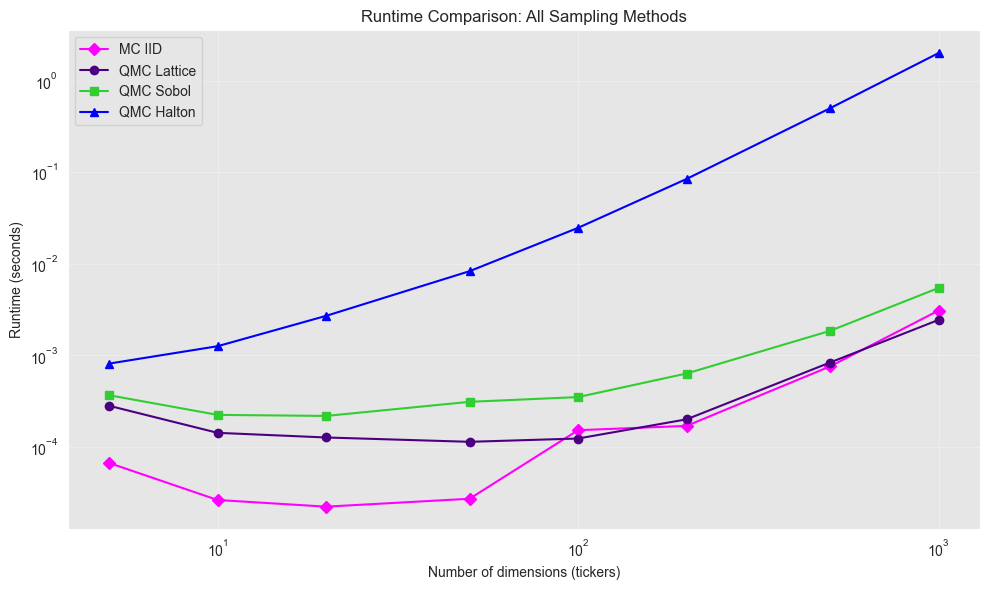

In [23]:
sn.set_style("darkgrid", {"axes.facecolor": ".9"})

dimensions = [5, 10, 20, 50, 100, 200, 500, 1000]

# Measure runtime for all sampling methods
plt.figure(figsize=(10, 6))

for sampler, color, marker in zip(sampler_types, colors, markers):
    times = []
    for n in dimensions:
        num_samples = 2**int(np.log2(n) + 1) # Use powers of 2 for lattice (required by default order)
        try:
            t = timeit.timeit(f'gen_weights("{sampler}", {n}, {num_samples})',
                      globals=globals(), number=1)
        except Exception as e:
            print(f"Skipping sampler={sampler} dim={n}: {e}")
            t = float('nan')
        times.append(t)
    plt.loglog(dimensions, times, color=color, marker=marker, linestyle='-',
               label=f'QMC {sampler.capitalize()}' if sampler != 'iid' else 'MC IID',
               linewidth=1.5, markersize=6)

plt.title("Runtime Comparison: All Sampling Methods", fontsize=12)
plt.legend()
plt.xlabel("Number of dimensions (tickers)")
plt.ylabel("Runtime (seconds)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/figure_1.png', bbox_inches='tight', dpi=150)
plt.show();

In [24]:
def plot_runtime(seed=SEED):
    """
    Generate runtime plots comparing QMC and MC samplers.
    
    Parameters:
        seed: Random seed for reproducibility
    """
    # Set seeds for reproducibility
    np.random.seed(seed)
    random.seed(seed)
    
    # Plot styling
    sn.set_style("darkgrid", {"axes.facecolor": ".9"})
    sampler_types = ['lattice', 'sobol', 'halton', 'iid']
    colors = ['indigo', 'limegreen', 'blue', 'magenta']
    markers = ['o', 's', '^', 'D']

    # Experiment configurations
    dimensions = [5, 10, 20, 50, 100, 200, 500, 1000]
    num_samples = [2**m for m in range(8, 18)] # 256 to 131072
    fixed_dimension = 50
    fixed_num_samples = 2**12
    repeats = 3

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    for sampler, color, marker in zip(sampler_types, colors, markers):

        # Runtime vs dimension
        times_dim = []
        for d in dimensions:
            try:
                t = timeit.timeit(
                    f'gen_weights("{sampler}", {d}, {fixed_num_samples}, seed={seed})',
                    globals=globals(),
                    number=repeats
                ) / repeats
            except Exception as e:
                print(f"Skipping sampler={sampler} dim={d}: {e}")
                t = float('nan')

            times_dim.append(t)

        axes[0].loglog(
            dimensions,
            times_dim,
            color=color,
            marker=marker,
            linestyle='-',
            label=f'QMC {sampler.capitalize()}' if sampler != 'iid' else 'MC IID',
            linewidth=1.5,
            markersize=6
        )

        # Runtime vs portfolios
        times_n = []
        for n in num_samples:
            try:
                t = timeit.timeit(
                    f'gen_weights("{sampler}", {fixed_dimension}, {n}, seed={seed})',
                    globals=globals(),
                    number=repeats
                ) / repeats
            except Exception as e:
                print(f"Skipping sampler={sampler} n={n}: {e}")
                t = float('nan')

            times_n.append(t)

        axes[1].loglog(
            num_samples,
            times_n,
            color=color,
            marker=marker,
            linestyle='-',
            linewidth=1.5,
            markersize=6
        )

    axes[0].set_xlabel("Number of dimensions (tickers)", fontweight='bold')
    axes[1].set_xlabel("Number of portfolios (samples)", fontweight='bold')
    axes[0].set_ylabel("Runtime (seconds)", fontweight='bold')
    axes[0].set_title(f"Runtime vs Tickers ({fixed_num_samples} portfolios)", fontsize=11, fontweight='bold')
    axes[1].set_title(f"Runtime vs Portfolios ({fixed_dimension} tickers)", fontsize=11, fontweight='bold')
    axes[0].grid(True, alpha=0.8)
    axes[1].grid(True, alpha=0.8)
    axes[0].legend()
    plt.tight_layout()
    plt.savefig('images/figure_2.png', bbox_inches='tight', dpi=150)
    plt.show();

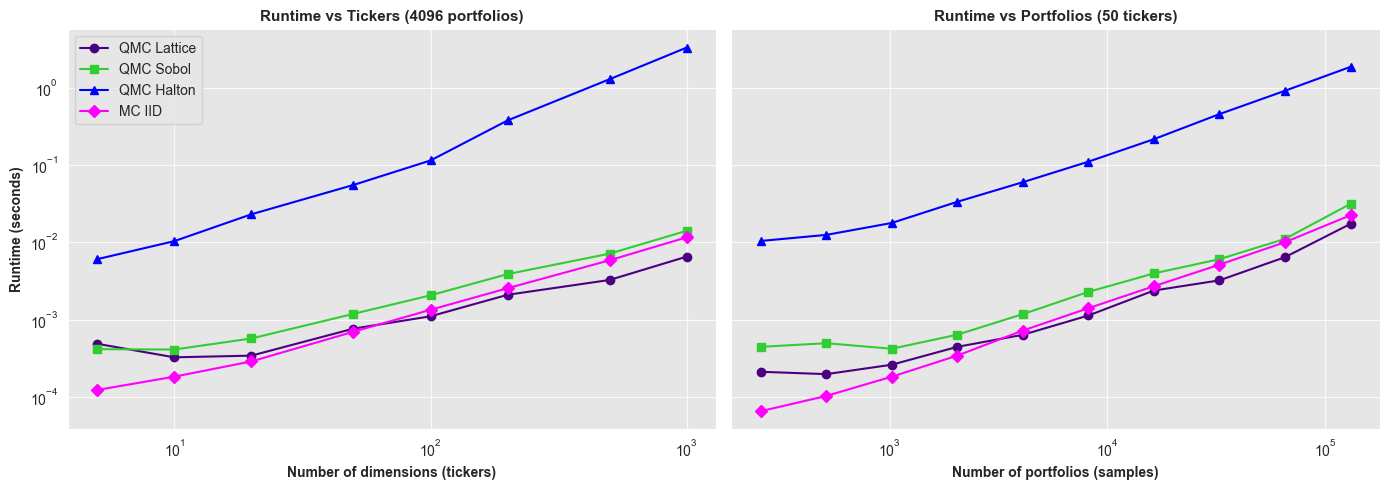

In [25]:
plot_runtime()

## CPU time

### Lattice CPU

In [26]:

lattice_results_cpu = []
for tickers, portfolios in params:
    start_time = time.process_time()
    lattice_weights = gen_weights('lattice', tickers, portfolios)
    end_time = time.process_time()
    time_taken = end_time - start_time
    lattice_results_cpu.append({
        'Tickers': tickers,
        'Portfolios': portfolios,
        'Lattice Time (s)': time_taken
    })

df_cpu_time =  pd.DataFrame(lattice_results_cpu)

### IID CPU

In [27]:
iid_results_cpu = []
for tickers, portfolios in params:
    start_time = time.process_time()
    iid_weights = gen_weights('iid', tickers, portfolios)
    end_time = time.process_time()
    time_taken = end_time - start_time
    iid_results_cpu.append(time_taken)

df_cpu_time['IID Time (s)'] = iid_results_cpu

In [28]:
df_cpu_time

,Tickers,Portfolios,Lattice Time (s),IID Time (s)
0,4,16384,0.024116,0.022864
1,10,32768,0.001443,0.001876
2,20,65536,0.002772,0.004115
3,100,131072,0.028565,0.043218
4,500,262144,0.342756,0.405200
5,1000,524288,1.314397,1.721773


## Backtesting

*Backtesting* - a method used to retrospectively evaluate the effectiveness of a strategy by simulating its performance using historical data

In [29]:
aapl = df[df['Ticker']== 'AAPL'].reset_index()
amzn = df[df['Ticker']== 'AMZN'].reset_index()
csco = df[df['Ticker']== 'CSCO'].reset_index()
ibm = df[df['Ticker']== 'IBM'].reset_index()

In [30]:
aapl = aapl.set_index('Date')
amzn = amzn.set_index('Date')
csco = csco.set_index('Date')
ibm = ibm.set_index('Date')


In [31]:
# normalize return
for stock_df in (aapl,  amzn, csco, ibm):
    stock_df['Norm Return'] = stock_df['Adj Close Price'] / stock_df.iloc[0]['Adj Close Price']

In [32]:
principal = 10000 # starting investment value
num_ports = 2**14  # 16384 portfolios
risk_level = "high"

# Generate weights and compute Sharpe ratios for all samplers
w_lattice = gen_weights('lattice', 4, num_ports)
sr_lattice = sharpe(w_lattice, lr)

w_sobol = gen_weights('sobol', 4, num_ports)
sr_sobol = sharpe(w_sobol, lr)

w_halton = gen_weights('halton', 4, num_ports)
sr_halton = sharpe(w_halton, lr)

w_iid = gen_weights('iid', 4, num_ports)
sr_iid = sharpe(w_iid, lr)

### Portfolio performance for all sampling methods
We compute portfolio values using weights from all four sampling methods: Lattice, Sobol, Halton (QMC), and IID (MC).

In [33]:
# Compute portfolio values for all sampling methods
def compute_portfolio_value(stock_dfs, weights_dict, risk_level, principal):
    """Compute total portfolio value over time given weights."""
    positions = []
    for stock_df, alloc in zip(stock_dfs, weights_dict[risk_level]):
        pos = stock_df['Norm Return'] * alloc * principal
        positions.append(pos)
    total = pd.concat(positions, axis=1).sum(axis=1)
    return total

# Get stock dataframes
stocks = (aapl, amzn, csco, ibm)

# Compute portfolio values for each method
portf_lattice = compute_portfolio_value(stocks, sr_lattice, risk_level, principal)
portf_sobol = compute_portfolio_value(stocks, sr_sobol, risk_level, principal)
portf_halton = compute_portfolio_value(stocks, sr_halton, risk_level, principal)
portf_iid = compute_portfolio_value(stocks, sr_iid, risk_level, principal)

In [34]:
# Combine all portfolio values into a single DataFrame
all_portfolios = pd.DataFrame({
    'Lattice': portf_lattice,
    'Sobol': portf_sobol,
    'Halton': portf_halton,
    'IID': portf_iid
})
all_portfolios

,Lattice,Sobol,Halton,IID
Date,,,,
2014-01-02,10000.000000,9990.000000,9990.000000,10000.000000
2014-01-03,9845.755500,9846.760156,9848.979319,9853.061530
2014-01-06,9868.323124,9867.615751,9868.850571,9876.785084
2014-01-07,9862.790923,9872.623351,9876.118185,9878.329011
2014-01-08,9921.902795,9925.647579,9930.199175,9932.045404
...,...,...,...,...
2025-12-08,137294.564616,131165.684288,130365.512602,132120.326496
2025-12-09,137180.303697,131080.647438,130298.584295,132027.900295
2025-12-10,138255.444749,132112.382909,131342.555080,133046.750869


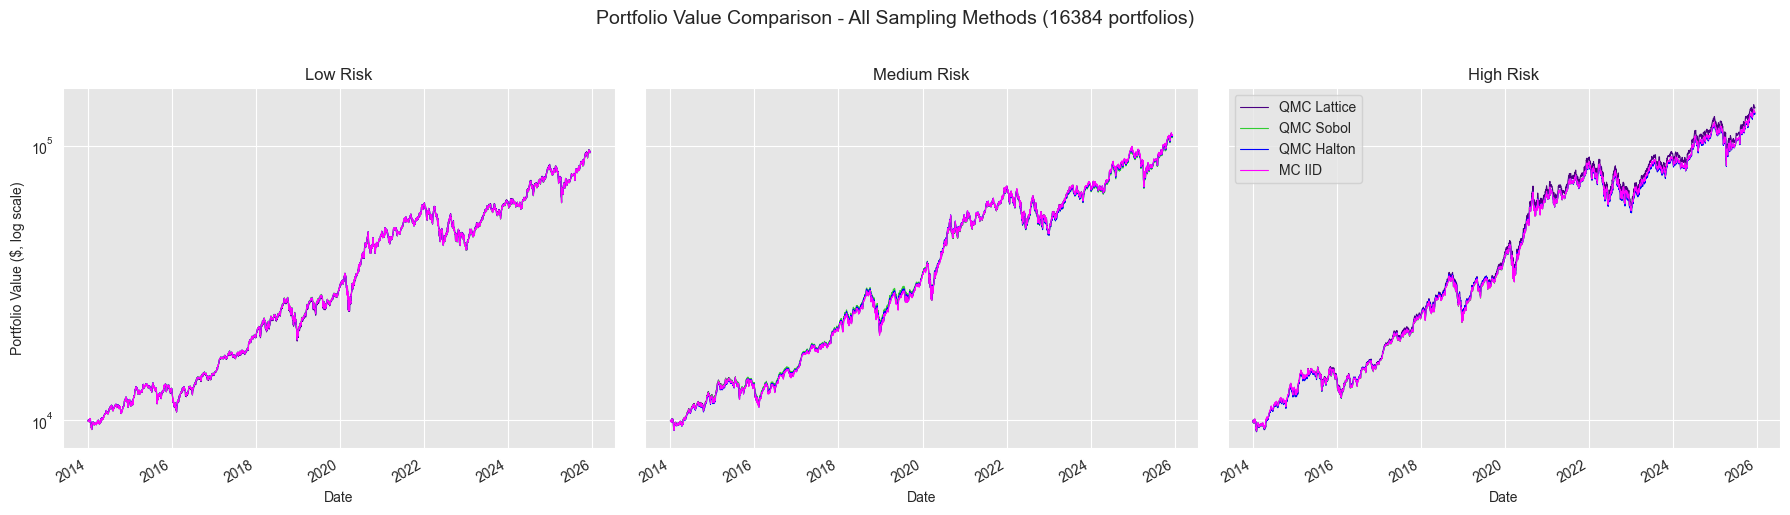

In [35]:
# Plot portfolio values for all sampling methods across all risk levels
sn.set_style("darkgrid", {"axes.facecolor": ".9"})
colors = ['indigo', 'limegreen', 'blue', 'magenta']
#colors = ['indigo', 'green', 'orange', 'red']
risk_levels = ['low', 'medium', 'high']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for idx, risk in enumerate(risk_levels):
    # Compute portfolio values for this risk level
    portf_data = pd.DataFrame({
        'Lattice': compute_portfolio_value(stocks, sr_lattice, risk, principal),
        'Sobol': compute_portfolio_value(stocks, sr_sobol, risk, principal),
        'Halton': compute_portfolio_value(stocks, sr_halton, risk, principal),
        'IID': compute_portfolio_value(stocks, sr_iid, risk, principal)
    })
    
    portf_data.plot(ax=axes[idx], logy=True, linewidth=0.8, color=colors, legend=(idx == 2))
    axes[idx].set_title(f'{risk.capitalize()} Risk', fontsize=12)
    axes[idx].set_xlabel('Date')
    if idx == 0:
        axes[idx].set_ylabel('Portfolio Value ($, log scale)')

# Add common legend
axes[2].legend(['QMC Lattice', 'QMC Sobol', 'QMC Halton', 'MC IID'], loc='upper left')
fig.suptitle(f'Portfolio Value Comparison - All Sampling Methods ({num_ports} portfolios)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('images/figure_3.png', bbox_inches='tight', dpi=150)
plt.show();

In [36]:
cat = 'low'
print(f"{cat} risk weights:")
print(f"Lattice: {sr_lattice[cat]}")
print(f"Sobol:   {sr_sobol[cat]}")
print(f"Halton:  {sr_halton[cat]}")
print(f"IID:     {sr_iid[cat]}")

low risk weights:
Lattice: [0.357, 0.154, 0.249, 0.24]
Sobol:   [0.344, 0.16, 0.271, 0.225]
Halton:  [0.35, 0.157, 0.263, 0.231]
IID:     [0.349, 0.158, 0.263, 0.23]


In [37]:
# Compute differences relative to IID baseline
differences = pd.DataFrame({
    'Lattice vs IID': (all_portfolios['Lattice'] - all_portfolios['IID']) / principal,
    'Sobol vs IID': (all_portfolios['Sobol'] - all_portfolios['IID']) / principal,
    'Halton vs IID': (all_portfolios['Halton'] - all_portfolios['IID']) / principal
})

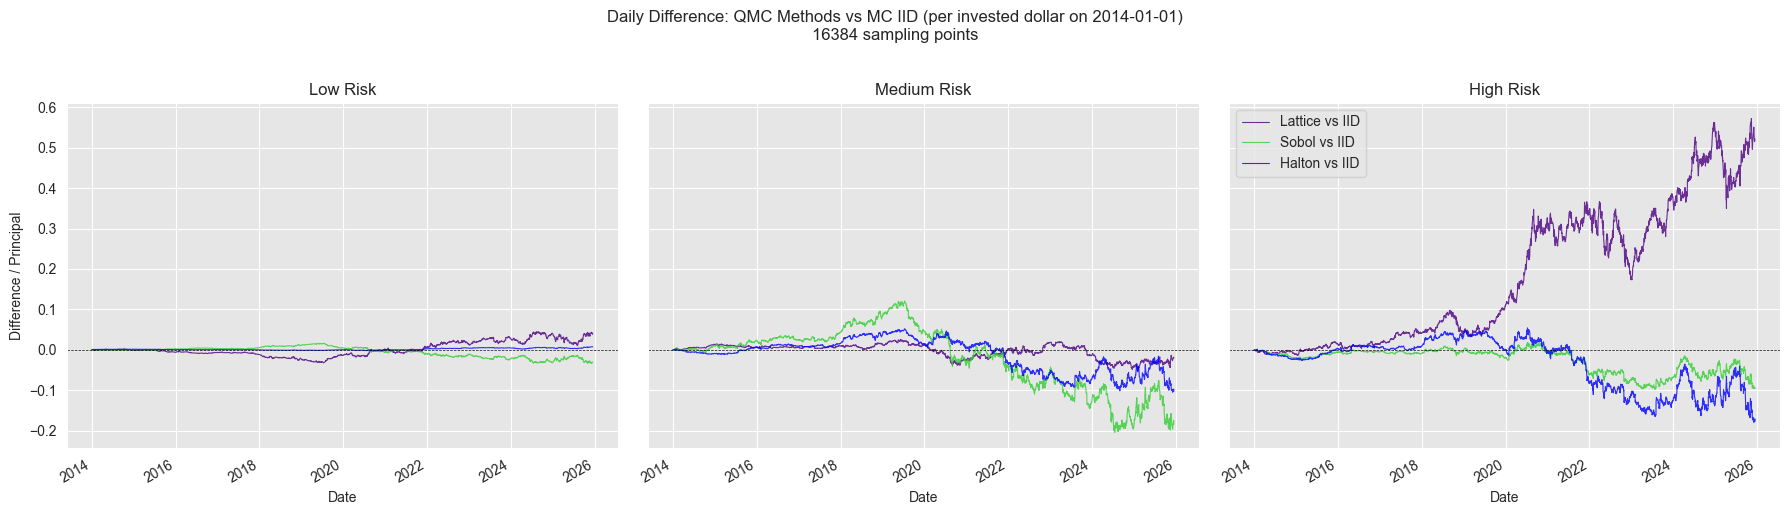

In [38]:
# Plot differences between QMC methods and MC IID for all risk levels
#colors_diff = ['indigo', 'green', 'orange']
colors_diff = ['indigo', 'limegreen', 'blue']
risk_levels = ['low', 'medium', 'high']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for idx, risk in enumerate(risk_levels):
    # Compute portfolio values for this risk level
    portf_lattice_r = compute_portfolio_value(stocks, sr_lattice, risk, principal)
    portf_sobol_r = compute_portfolio_value(stocks, sr_sobol, risk, principal)
    portf_halton_r = compute_portfolio_value(stocks, sr_halton, risk, principal)
    portf_iid_r = compute_portfolio_value(stocks, sr_iid, risk, principal)
    
    # Compute differences
    diff_data = pd.DataFrame({
        'Lattice vs IID': (portf_lattice_r - portf_iid_r) / principal,
        'Sobol vs IID': (portf_sobol_r - portf_iid_r) / principal,
        'Halton vs IID': (portf_halton_r - portf_iid_r) / principal
    })
    
    diff_data.plot(ax=axes[idx], linewidth=0.8, color=colors_diff, alpha=0.8, legend=(idx == 2))
    axes[idx].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    axes[idx].set_title(f'{risk.capitalize()} Risk', fontsize=12)
    axes[idx].set_xlabel('Date')
    if idx == 0:
        axes[idx].set_ylabel('Difference / Principal')

# Add common legend
axes[2].legend(loc='upper left')
fig.suptitle(f'Daily Difference: QMC Methods vs MC IID (per invested dollar on {start_date})\n{num_ports} sampling points', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig('images/figure_4.png', bbox_inches='tight', dpi=150)
plt.show();

# References

1. **QMCPy**: Choi, S.-C. T., Hickernell, F. J., McCourt, M., Rathinavel, J., & Sorokin, A. (2020). QMCPy: A quasi-Monte Carlo Python library. https://qmcpy.org/

2. **Sharpe Ratio**: Sharpe, W. F. (1966). Mutual fund performance. *Journal of Business*, 39(1), 119-138.

3. **Low-Discrepancy Sequences**: Niederreiter, H. (1992). *Random Number Generation and Quasi-Monte Carlo Methods*. SIAM.

4. **Lattice Rules**: Sloan, I. H., & Joe, S. (1994). *Lattice Methods for Multiple Integration*. Oxford University Press.

5. **Sobol Sequences**: Sobol', I. M. (1967). On the distribution of points in a cube and the approximate evaluation of integrals. *USSR Computational Mathematics and Mathematical Physics*, 7(4), 86-112.

6. **Portfolio Theory**: Markowitz, H. (1952). Portfolio selection. *Journal of Finance*, 7(1), 77-91.

7. **Simplex Transformation for Low-Discrepany Sequences (1)** : Pillards, T., & Cools, R. (2005). Transforming low-discrepancy sequences from a cube to a simplex. *Journal of Computational and Applied Mathematics*, 174(1), 29–42. 

8. **Simplex Transformation for Low-Discrepany Sequences (2)** : Basu, K., & Owen, A. B. (2016). Transformations and Hardy–Krause variation. *SIAM Journal on Numerical Analysis*, 54(3), 1946–1966.

